<a id='home'></a>

# Modelo de priorização de clientes

## Conteúdo

- [Análise exploratória dos dados](#explora)
- [Pré-processamento, limpeza, e remoção de dados](#dataprep)
- [Modelos de classificação](#modelo)
  - [Bernoulli naive bayes](#texto)
  - [Árvore de decisão contínua](#numer)
  - [Árvore de decisão categórica](#categ)
  - [Stacking de modelos](#stack)
- [Avaliação da solução](#avalia)
- [Importância das variáveis](#importance)

<a id='explora'></a>

## Análise exploratória dos dados

[topo](#home)

In [1]:
%matplotlib inline

import sys

sys.path.append('../python')

from modelos import clf_bnb
from modelos import clf_dt1
from modelos import clf_dt2

from myutils import amostragem, dataprep
from myplots import plot_roc

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv('../dados/dataset.csv') \
    .drop_duplicates()

dataset.head(2)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN


In [3]:
pre_aprovados = dataset.pre_approved.value_counts()

print('Solicitações pré-aprovadas:', pre_aprovados[1])

Solicitações pré-aprovadas: 14998


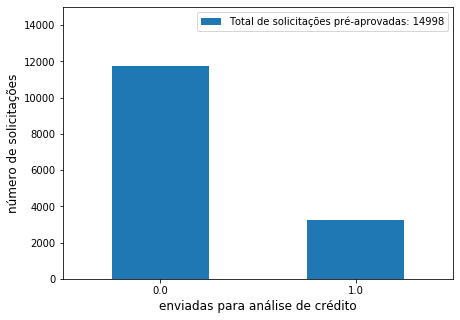

In [4]:
enviadas = dataset[dataset.pre_approved==1.0]['sent_to_analysis'].value_counts()

label = f'Total de solicitações pré-aprovadas: {pre_aprovados[1]}' 

enviadas.plot.bar(rot=0, figsize=(7, 5), label=label)

plt.ylabel('número de solicitações', fontsize='large')
plt.xlabel('enviadas para análise de crédito', fontsize='large')
plt.ylim(0, 15e3)
plt.legend();

In [5]:
print('Solicitações pré-aprovadas e enviadas para análise de crédito:', enviadas[1])

Solicitações pré-aprovadas e enviadas para análise de crédito: 3269


<a id='dataprep'></a>

## Pré-processamento, limpeza, e remoção de dados

[topo](#home)

In [6]:
publico = dataprep(dataset)

In [7]:
print(f'   {"coluna":>25} {"tipo":>10} {"unicos":>10} {"nulos":>10}')
      
for i, col in enumerate(publico.columns):
    col_dtype = str(publico[col].dtype)
    col_count = publico[col].nunique()
    col_nulos = publico[col].isna().sum()
    print(f'{i+1:>2} {col:>25} {col_dtype:>10} {col_count:>10} {col_nulos:>10}')

                      coluna       tipo     unicos      nulos
 1                        id      int64       7316          0
 2                       age    float64         56          0
 3            monthly_income    float64        846          0
 4               loan_amount    float64        607          0
 5                      city     object        230          0
 6                     state     object         27          0
 7         dishonored_checks      int64          2          0
 8             banking_debts      int64          2          0
 9          commercial_debts      int64          2          0
10                  protests      int64          2          0
11      informed_restriction     object          3          0
12           monthly_payment    float64       1518          0
13          informed_purpose     object       4790          0
14                auto_brand     object         15          0
15                auto_model     object        319          0
16      

<a id='modelo'></a>

## Modelos de classificação

[topo](#home)

In [8]:
""" Amostras de treino, teste e validação
"""

target = 'sent_to_analysis'

df_train, df_teste, df_valid = amostragem(publico, target)

print('train:', df_train.shape)
print('teste:', df_teste.shape)
print('valid:', df_valid.shape)

train: (4389, 25)
teste: (1463, 25)
valid: (1464, 25)


In [9]:
le = LabelEncoder()

le.fit(['0.0', '1.0']);

In [10]:
y_train = le.transform(df_train[target])
y_teste = le.transform(df_teste[target])
y_valid = le.transform(df_valid[target])

X_train = df_train.drop(target, axis=1)
X_teste = df_teste.drop(target, axis=1)
X_valid = df_valid.drop(target, axis=1)

<a id='texto'></a>

### Bernoulli Naive bayes

[topo](#home)

In [11]:
%%time

X_train_bnb = X_train.informed_purpose
X_teste_bnb = X_teste.informed_purpose
X_valid_bnb = X_valid.informed_purpose

bnb = clf_bnb(X_train_bnb, y_train)

bnb_score_teste = bnb.predict_proba(X_teste_bnb)[:, 1]
bnb_score_valid = bnb.predict_proba(X_valid_bnb)[:, 1]

CPU times: user 48.2 ms, sys: 0 ns, total: 48.2 ms
Wall time: 47.6 ms


<a id='numer'></a>

### Árvore de decisão contínua

[topo](#home)

In [12]:
%%time

X_train_dt1 = X_train.select_dtypes(include=['float64'])
X_teste_dt1 = X_teste.select_dtypes(include=['float64'])
X_valid_dt1 = X_valid.select_dtypes(include=['float64'])

dt1 = clf_dt1(X_train_dt1, y_train)

dt1_score_teste = dt1.predict_proba(X_teste_dt1)[:, 1]
dt1_score_valid = dt1.predict_proba(X_valid_dt1)[:, 1]

CPU times: user 21.6 ms, sys: 533 µs, total: 22.1 ms
Wall time: 20.2 ms


<a id='categ'></a>

### Árvore de decisão categórica

[topo](#home)

In [13]:
%time

X_train_dt2 = X_train.select_dtypes(include=['int64', 'object'])
X_teste_dt2 = X_teste.select_dtypes(include=['int64', 'object'])
X_valid_dt2 = X_valid.select_dtypes(include=['int64', 'object'])

dt2 = clf_dt2(X_train_dt2, y_train)

dt2_score_teste = dt2.predict_proba(X_teste_dt2)[:, 1]
dt2_score_valid = dt2.predict_proba(X_valid_dt2)[:, 1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


<a id='stack'></a>

### Stacking de modelos

[topo](#home)

In [14]:
X_teste_stack = np.c_[
    dt2_score_teste,
    dt1_score_teste,
    bnb_score_teste,
]

X_valid_stack = np.c_[
    dt2_score_valid,
    dt1_score_valid,
    bnb_score_valid,
]

In [15]:
reg = LogisticRegression(random_state=42, solver='lbfgs')

auc_scores = []

for i in range(1, 4):
    reg.fit(X_teste_stack[:, :i], y_teste)
    reg_score = reg.predict_proba(X_valid_stack[:, :i])[:, 1]
    reg_auc = roc_auc_score(y_valid, reg_score)
    auc_scores.append(reg_auc)
    
reg_score_valid = reg_score

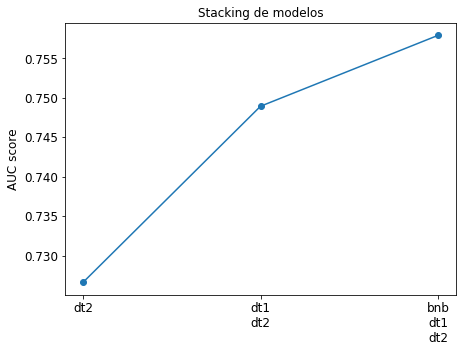

In [16]:
plt.subplots(figsize=(7, 5))

modelos = [
    'dt2',
    'dt1\ndt2',
    'bnb\ndt1\ndt2',
]

plt.plot(modelos, auc_scores, 'o-')
plt.tick_params(labelsize='large')
plt.title('Stacking de modelos', fontsize='large')
plt.ylabel('AUC score', fontsize='large');

<a id='avalia'></a>

## Avaliação da solução

[topo](#home)

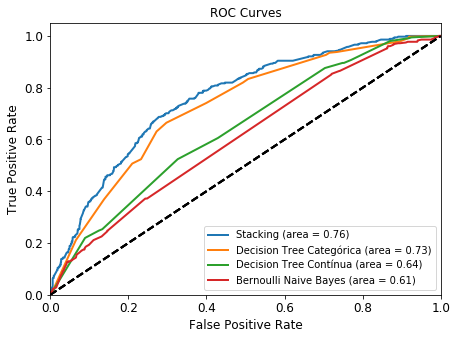

In [17]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
                  
plot_roc(y_valid, reg_score_valid, label='Stacking', ax=ax)
plot_roc(y_valid, dt2_score_valid, label='Decision Tree Categórica', ax=ax)
plot_roc(y_valid, dt1_score_valid, label='Decision Tree Contínua', ax=ax)
plot_roc(y_valid, bnb_score_valid, label='Bernoulli Naive Bayes', ax=ax);

<a id='importance'></a>

## Importância das variáveis

[topo](#home)

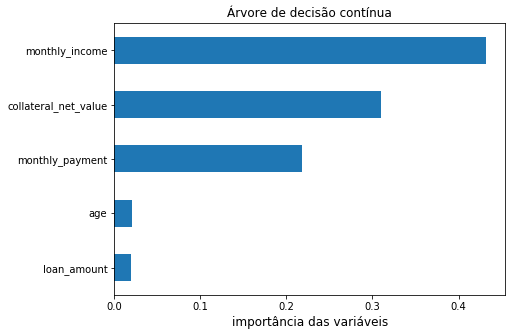

In [18]:
dt1_columns = [
    'age',
    'monthly_income',
    'loan_amount',
    'monthly_payment',
    'collateral_net_value',
]

dt1_importances = dt1.steps[1][1].feature_importances_

df = pd.DataFrame(
    data=dt1_importances,
    index=dt1_columns
).sort_values(by=0)

df.plot.barh(figsize=(7, 5))

plt.title('Árvore de decisão contínua', fontsize='large')
plt.xlabel('importância das variáveis', fontsize='large')
plt.legend().remove()

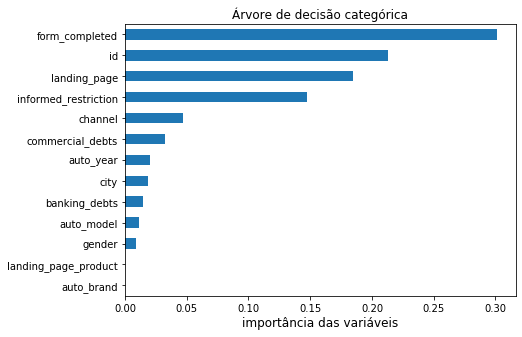

In [19]:
dt2_columns = [
    'id',
    'banking_debts',
    'commercial_debts',
    'city',
    'informed_restriction',
    'form_completed',
    'auto_model',
    'auto_brand',
    'auto_year',
    'channel',
    'landing_page',
    'landing_page_product',
    'gender',
]

dt2_importances = dt2.steps[1][1].feature_importances_

df = pd.DataFrame(
    data=dt2_importances,
    index=dt2_columns
).sort_values(by=0)

df.plot.barh(figsize=(7, 5))

plt.title('Árvore de decisão categórica', fontsize='large')
plt.xlabel('importância das variáveis', fontsize='large')
plt.legend().remove()